In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader  # For custom dataset and batching

In [93]:
import os
import requests
import gzip
import shutil

# Updated URLs for MNIST dataset
urls = [
    "https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz",
    "https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz",
    "https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz",
    "https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz"
]

# Directory to store data
os.makedirs("./data", exist_ok=True)

# Function to download files
def download_file(url, save_dir="./data"):
    filename = os.path.join(save_dir, url.split("/")[-1])
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        print(f"Downloading {filename}...")
        with open(filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
        print(f"Downloaded {filename}")
    else:
        print(f"Failed to download {url}: {response.status_code}")

# Download all files
for url in urls:
    download_file(url)

# Function to extract .gz files
def extract_gz_files(source_dir="./data"):
    for file in os.listdir(source_dir):
        if file.endswith(".gz"):
            file_path = os.path.join(source_dir, file)
            extracted_path = file_path.replace(".gz", "")
            print(f"Extracting {file_path}...")
            with gzip.open(file_path, 'rb') as f_in:
                with open(extracted_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            print(f"Extracted to {extracted_path}")

# Extract all downloaded files
extract_gz_files("./data")



Downloaded ./data/train-images-idx3-ubyte.gz
Downloaded ./data/train-labels-idx1-ubyte.gz
Downloaded ./data/t10k-images-idx3-ubyte.gz
Downloaded ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz...
Extracted to ./data/t10k-images-idx3-ubyte
Extracting ./data/train-images-idx3-ubyte.gz...
Extracted to ./data/train-images-idx3-ubyte
Extracting ./data/train-labels-idx1-ubyte.gz...
Extracted to ./data/train-labels-idx1-ubyte
Extracting ./data/t10k-labels-idx1-ubyte.gz...
Extracted to ./data/t10k-labels-idx1-ubyte


In [94]:
import numpy as np
import struct

def load_images(file_path):
    with open(file_path, 'rb') as f:
        # Read the header
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        assert magic == 2051, "Invalid magic number for image file!"
        # Read the image data and reshape it
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
    return images

def load_labels(file_path):
    with open(file_path, 'rb') as f:
        # Read the header
        magic, num_labels = struct.unpack(">II", f.read(8))
        assert magic == 2049, "Invalid magic number for label file!"
        # Read the label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# Load training data
train_images = load_images('./data/train-images-idx3-ubyte')
train_labels = load_labels('./data/train-labels-idx1-ubyte')

# Load test data
test_images = load_images('./data/t10k-images-idx3-ubyte')
test_labels = load_labels('./data/t10k-labels-idx1-ubyte')

# Print shapes for verification
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")

Train Images Shape: (60000, 28, 28)
Train Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)


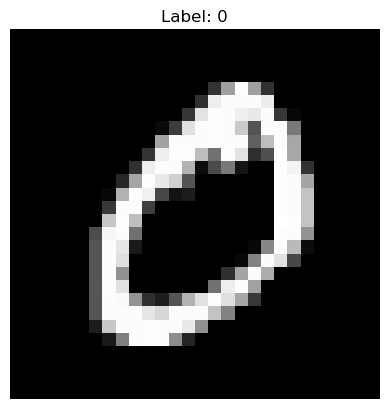

In [95]:
import matplotlib.pyplot as plt

# Select an image and label to display
index = 1  # Change this to see other images
image = train_images[index].astype(np.float32)  # Convert to float for better rendering
label = train_labels[index]

# Plot the image
plt.imshow(image, cmap='gray', interpolation='nearest')  # Ensure grayscale rendering
plt.title(f"Label: {label}")
plt.axis('off')  # Remove axis for clarity
plt.show()


In [96]:
len(train_images)

60000

## Creating a Custom Dataset

In [97]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Custom MNIST dataset.
        Args:
            images: NumPy array or tensor of shape (N, 28, 28).
            labels: NumPy array or tensor of shape (N,).
            transform: Optional. A callable that applies transformations to the images.
        """
        # Convert NumPy arrays to tensors during initialization
        self.images = torch.tensor(images, dtype=torch.float32) #Default is usually float32
        self.labels = torch.tensor(labels, dtype=torch.long) # Type long for classification
        self.transform = transform if transform else self.default_transform() #Apply default transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """
        Fetch an image and its corresponding label.
        Args:
            idx: Index of the image and label to retrieve.
        Returns:
            Tuple (transformed_image, label).
        """
        # Access the image and label directly as tensors
        image = self.images[idx].unsqueeze(0)  # Add channel dimension (C, H, W)
        label = self.labels[idx]

        # Apply the transform
        image = self.transform(image)

        return image, label

    def default_transform(self):
        """
        Define the default transformation pipeline for MNIST.
        Returns:
            A callable transform.
        """
        return transforms.Compose([
            transforms.Normalize((0.5,), (0.5,)),  # Normalize to mean 0.5, std 0.5
        ])

In [98]:
MNISTDataset(train_images, train_labels).images.shape

torch.Size([60000, 28, 28])

In [99]:
MNISTDataset(train_images, train_labels).default_transform()

Compose(
    Normalize(mean=(0.5,), std=(0.5,))
)

In [102]:
MNISTDataset(train_images, train_labels).__getitem__(1)[0].shape# Return "image" at idx 1

torch.Size([1, 28, 28])

In [52]:
MNISTDataset(train_images, train_labels).__getitem__(1)[1] # Return label at idx 1

tensor(0)

In [20]:
train_loader = DataLoader(MNISTDataset(train_images, train_labels), batch_size=64, shuffle=True)
test_loader = DataLoader(MNISTDataset(test_images, test_labels), batch_size=64)

## Defining the Architecture

In [67]:
class DynamicFCNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_sizes=[128, 64], output_size=10):
        """
        Fully connected neural network with dynamic hidden layer sizes.
        Args:
            input_size (int): Number of input features (e.g., 28*28 for MNIST).
            hidden_sizes (list): List of sizes for the hidden layers.
            output_size (int): Number of output classes (e.g., 10 for MNIST digits).
        """
        super(DynamicFCNN, self).__init__()
        
        # Create a list to store layers
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        
        # Hidden layers - It will iterate through so you can enter more layers in the definition 
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.ReLU())
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        # Register all layers in a Sequential module
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        """
        Forward pass through the network.
        Args:
            x (torch.Tensor): Input tensor (batch_size, input_size).
        Returns:
            torch.Tensor: Output tensor (batch_size, output_size).
        """
        x = x.view(x.size(0), -1)
        return self.network(x)

In [ ]:
import torch.nn as nn

class SimpleFCNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, output_size=10):
        """
        Fully connected neural network with a single hidden layer.
        Args:
            input_size (int): Number of input features (e.g., 28*28 for MNIST).
            hidden_size (int): Size of the hidden layer.
            output_size (int): Number of output classes (e.g., 10 for MNIST digits).
        """
        super(SimpleFCNN, self).__init__()
        
        # Define the network layers
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),  # Input to hidden layer
            nn.ReLU(),                           # Activation function
            nn.Linear(hidden_size, output_size)  # Hidden to output layer
        )
    
    def forward(self, x):
        """
        Forward pass through the network.
        Args:
            x (torch.Tensor): Input tensor (batch_size, input_size).
        Returns:
            torch.Tensor: Output tensor (batch_size, output_size).
        """
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.network(x)


In [68]:
base_model = DynamicFCNN(input_size=28*28, hidden_sizes=[128, 64], output_size=10)
print(base_model)

DynamicFCNN(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [70]:
def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test data.
    
    Args:
        model (torch.nn.Module): The trained model.
        test_loader (DataLoader): DataLoader for the test data.
    
    Returns:
        float: Accuracy of the model on the test dataset.
    """
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total


In [76]:
def train_model(
    model,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    num_epochs=5,
    verbose=True
):
    """
    Train a PyTorch model and evaluate its performance.
    
    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training data.
        test_loader (DataLoader): DataLoader for the test data.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        criterion (torch.nn.Module): Loss function.
        num_epochs (int): Number of epochs to train.
        verbose (bool): If True, prints training progress.
    
    Returns:
        dict: A dictionary containing training loss and test accuracy.
    """
    model.train()  # Set model to training mode
    train_losses = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track loss
            running_loss += loss.item()
        
        # Average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        if verbose:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    # Evaluate the model on the test set
    test_accuracy = evaluate_model(model, test_loader)
    
    if verbose:
        print(f"Test Accuracy: {test_accuracy:.2f}%")

In [77]:
train_model(
    model=base_model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=torch.optim.Adam(base_model.parameters(), lr=0.001),
    criterion=torch.nn.CrossEntropyLoss(),
    num_epochs=5,
    verbose=True
)

Epoch [1/5], Loss: 0.0736
Epoch [2/5], Loss: 0.0709
Epoch [3/5], Loss: 0.0576
Epoch [4/5], Loss: 0.0579
Epoch [5/5], Loss: 0.0598
Test Accuracy: 96.98%
